<a href="https://colab.research.google.com/github/Rafi653/Machine-Learning/blob/feature%2Flab1/ML_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Linear Regression

In [155]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [4]:
from google.colab import files
file = files.upload()  #upload file into google colab session

df= pd.read_csv('housing.csv')

Saving housing.csv to housing.csv


In [5]:
df.head()
df.shape

(505, 14)

In [5]:
df.corr()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0.00632,1.000000,-0.200283,0.406251,-0.056132,0.420934,-0.218978,0.352701,-0.379626,0.625395,0.582568,0.289393,-0.384838,0.455328,-0.388249
18,-0.200283,1.000000,-0.534022,-0.042550,-0.516574,0.311835,-0.569524,0.664396,-0.311717,-0.314351,-0.391713,0.175319,-0.412894,0.360393
2.31,0.406251,-0.534022,1.000000,0.062350,0.764556,-0.391330,0.645543,-0.708848,0.594167,0.720561,0.380955,-0.356506,0.602737,-0.484126
0,-0.056132,-0.042550,0.062350,1.000000,0.091134,0.091497,0.086461,-0.099109,-0.007907,-0.035965,-0.122570,0.049040,-0.054576,0.175364
0.538,0.420934,-0.516574,0.764556,0.091134,1.000000,-0.302127,0.731461,-0.769220,0.611758,0.668141,0.188918,-0.380006,0.591262,-0.427295
6.575,-0.218978,0.311835,-0.391330,0.091497,-0.302127,1.000000,-0.240211,0.205170,-0.209277,-0.291680,-0.355116,0.127754,-0.613734,0.695365
65.2,0.352701,-0.569524,0.645543,0.086461,0.731461,-0.240211,1.000000,-0.747872,0.456232,0.506527,0.261724,-0.273486,0.602782,-0.376932
4.09,-0.379626,0.664396,-0.708848,-0.099109,-0.769220,0.205170,-0.747872,1.000000,-0.494797,-0.534492,-0.232560,0.291451,-0.497276,0.249895
1,0.625395,-0.311717,0.594167,-0.007907,0.611758,-0.209277,0.456232,-0.494797,1.000000,0.910202,0.463322,-0.444065,0.487608,-0.381690
296,0.582568,-0.314351,0.720561,-0.035965,0.668141,-0.291680,0.506527,-0.534492,0.910202,1.000000,0.460100,-0.441505,0.543435,-0.468543


In [156]:
class LinearRegression:
    def __init__(self, X, y, learningRate, tolerance, maxIteration, gd= False, stochastic=False, reg = False, batch_size =100) -> None:
        self.X= X
        self.y= y
        self.tolerance= tolerance
        self.learningRate= learningRate
        self.maxIteration= maxIteration
        self.gd= gd
        self.stochastic = stochastic
        self.batch_size = batch_size
        
    def splitTrainTest(self):
        X_train, X_test, y_train, y_test= train_test_split(self.X, self.y,
                                                           test_size= 0.3,
                                                           random_state=1)
        return (X_train, X_test, y_train, y_test)
    
    def add_X0(self,X):
        return np.column_stack([np.ones([X.shape[0],1]), X])
    
    def normalize(self,X):
        mean= np.mean(X,0)
        std= np.std(X,0)
        X_norm= (X - mean)/ std
        X_norm= self.add_X0(X_norm)
        return X_norm, mean, std
    
    def normalizetestdata(self, X, meanTrain, stdTrain):
        return (X- meanTrain)/ stdTrain

    def l2_regularization(self):
      pass
    
    def checkMatrix(self, X):
        X_rank= np.linalg.matrix_rank(X)
        
        if X_rank== min(X.shape[0], X.shape[1]):
            self.fullRank= True
            print('data is full rank')
        else:
            self.fullRank= False
            print('data is not full rank')
            
    def checkInvertibility(self,X):
        if X.shape[0] < X.shape[1]:
            self.lowRank= True
        else:
            self.lowrank= False
            
    def closedFormSolution(self, X,y):
        w= np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        return w

    def sgd_sample(self, X, y):
       
        n_obs = X.shape[0]

        xy = np.c_[X.reshape(n_obs, -1), y.reshape(n_obs, 1)]

        # Initializing the random number generator
        #seed = None if random_state is None else int(random_state)
        rng = np.random.default_rng(seed=2)

        rng.shuffle(xy)
        if not 0 < self.batch_size <= n_obs:
            raise ValueError(f"'batch_size' must be greater than zero and less than or equal to the number of observations: {n_obs}")
        start = random.randint(0, n_obs - self.batch_size)

        stop = start + self.batch_size
        x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]
        y_batch = y_batch.reshape(-1)
        
        return x_batch, y_batch
    
    def gradientDescent(self,X,y):
        
        self.errors= []
        
        lastError= float('inf')
        print(X.shape)
        print(y.shape)
        for t in tqdm(range(self.maxIteration)):
            if self.stochastic:
                print("solving using stochastic gradient descent")
                X_batch, y_batch = self.sgd_sample(X, y)
            else:
                print("solving using gradient descent")
                X_batch, y_batch = X, y
            
            self.w= self.w - self.learningRate * self.costDerivation(X_batch,y_batch)
            
            cur= self.sse(X_batch,y_batch)
            
            diff= lastError - cur
            lastError= cur
            self.errors.append(cur)
            
            if abs(diff) < self.tolerance:
                print("The model stopped and no further improvement")
                break
        self.plot_cost(self.errors)
            
    def predict(self, X):
        return X.dot(self.w)
    
    def sse(self, X, y):
        y_hat= self.predict(X)
        return((y_hat-y)**2).sum()
    
    def costFunction(self, X, y):
        return self.sse(X, y)/ 2
    
    def costDerivation(self, X, y):
        y_hat= self.predict(X)
        return(y_hat - y).dot(X)

    def plot_cost(self, cost_sequence):
    # Data for plotting
      s = np.array(cost_sequence)
      t = np.arange(s.size)

      fig, ax = plt.subplots()
      ax.plot(t, s)

      ax.set(xlabel='iterations', ylabel='cost',
              title='cost trend')
      ax.grid()

      plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
      plt.show()

    def fit(self):
        
        self.X_train, self.X_test, self.y_train, self.y_test= self.splitTrainTest()
        
        #normalize the data
        self.X_train, meanTrain, stdTrain= self.normalize(self.X_train)
        self.X_test= self.normalizetestdata(self.X_test, meanTrain, stdTrain)
        
        self.checkInvertibility(self.X_train)
        self.checkMatrix(self.X_train)
        
        if self.fullRank and not self.lowrank and not self.gd:
            print("Solving using Normal equation - closed form solution")
            self.w= self.closedFormSolution(self.X_train, self.y_train)
            
        else:
            self.w= np.ones(self.X_train.shape[1], dtype= np.float64)*0
            self.gradientDescent(self.X_train, self.y_train)
            
            print(self.w)

In [7]:
regression = LinearRegression(df.values[:,0:-1],
                              df.values[:, -1],
                              learningRate= 0.000001,
                              tolerance= 0.000005,
                              maxIteration= 10000,
                              gd= False)

In [8]:
regression.fit()

data is full rank
Solving using Normal equation - closed form solution


In [9]:
regression = LinearRegression(df.values[:,0:-1],
                              df.values[:, -1],
                              learningRate= 0.000001,
                              tolerance= 0.000005,
                              maxIteration= 10000,
                              gd= True)

In [10]:
regression.fit()

data is full rank
solving using gradient descent


100%|██████████| 10000/10000 [00:00<00:00, 43824.51it/s]

[21.73737909 -0.48223426  0.67929434 -0.54526329  0.94159179 -1.17844607
  2.71428393 -0.36828244 -1.93599005  0.76730127 -0.45131064 -1.59940807
  0.53796905 -3.37675097]


In [141]:
regression = LinearRegression(df.values[:,0:-1],
                              df.values[:, -1],
                              learningRate= 0.000001,
                              tolerance= 0.000005,
                              maxIteration= 50000,
                              gd= True)

In [142]:
regression.fit()

data is full rank
solving using gradient descent
(353, 14)
(353,)


100%|██████████| 50000/50000 [00:01<00:00, 48414.23it/s]

[22.39320065 -0.76256258  1.42745569 -0.18606945  0.88613824 -2.6011521
  2.09074456 -0.08336346 -3.57569168  2.11750482 -1.43787621 -1.73404394
  0.37475875 -4.09387352]


In [157]:
regression = LinearRegression(df.values[:,0:-1],
                              df.values[:, -1],
                              learningRate= 0.000001,
                              tolerance= 0.000005,
                              maxIteration= 10000,
                              gd= True, 
                              stochastic = True, 
                              batch_size = 200)

data is full rank
solving using gradient descent
(353, 14)
(353,)


100%|██████████| 10000/10000 [00:07<00:00, 1350.83it/s]
No handles with labels found to put in legend.


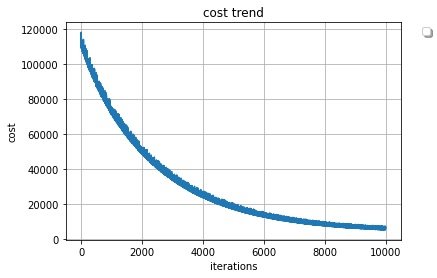

[19.15195796 -0.72458487  0.62488832 -0.52406552  0.99903257 -0.76073672
  2.29891785 -0.21000326 -1.13156234  0.33729527 -0.53236277 -1.21237008
  0.54598708 -2.89620808]


In [158]:
regression.fit()